In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

In [289]:
data = pd.read_json('example.json')
res = []
for i,row in data.iterrows():
    res.append(' '.join(row.tolist()[0]))
    

In [ ]:
model = TfidfVectorizer(sublinear_tf=True)
vec = model.fit_transform(res)
vec

In [ ]:
len(vec.todense())

In [ ]:
pca = PCA(0.90)
transformed = pca.fit_transform(np.asarray(vec.todense()))

In [ ]:
new = np.asarray(vec.todense())
new.shape


In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
vars = []
for i in range(5,200,25):
    m = TruncatedSVD(n_components=i)
    m.fit_transform(new)
    var = m.explained_variance_ratio_.sum()
    vars.append(var)


In [ ]:
new.size

In [ ]:
plt.plot(range(5,200,25),vars)

In [ ]:
## Install libraries
! python -m pip install --upgrade pip 
! pip install spacy 
! pip3 install spacy-transformers 
! python -m spacy download en_core_web_trf


In [ ]:
import spacy
#Load bert model
nlp = spacy.load("en_core_web_trf")

# Utility function for generating sentence embedding from the text
def get_embeddings(text):
    return nlp(text).vector
embeddings = list(map(get_embeddings,res))

In [ ]:
embeddings

In [227]:
from sentence_transformers import SentenceTransformer,util
import umap
import hdbscan

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = embedder.encode(res,convert_to_tensor=True)

clusters = util.community_detection(embeddings, min_community_size=5)
# this is valled topp2vec

clusters

[]

In [228]:
umap_embeddings = umap.UMAP(n_neighbors=15,n_components=5,metric='cosine').fit_transform(embeddings)

In [ ]:
cluster = hdbscan.HDBSCAN(
    metric="euclidean"
).fit(umap_embeddings)


In [ ]:
result['labels'] = cluster.labels_

result.head()
result.plot.scatter('x','y',c='labels')



In [ ]:
from nltk.cluster import KMeansClusterer

for i in range(2,12,2):
    model = KMeans(n_clusters=i)
    model.fit(embeddings)

In [ ]:
final = TruncatedSVD(n_components=160)
transformed = final.fit_transform(new)
X = transformed

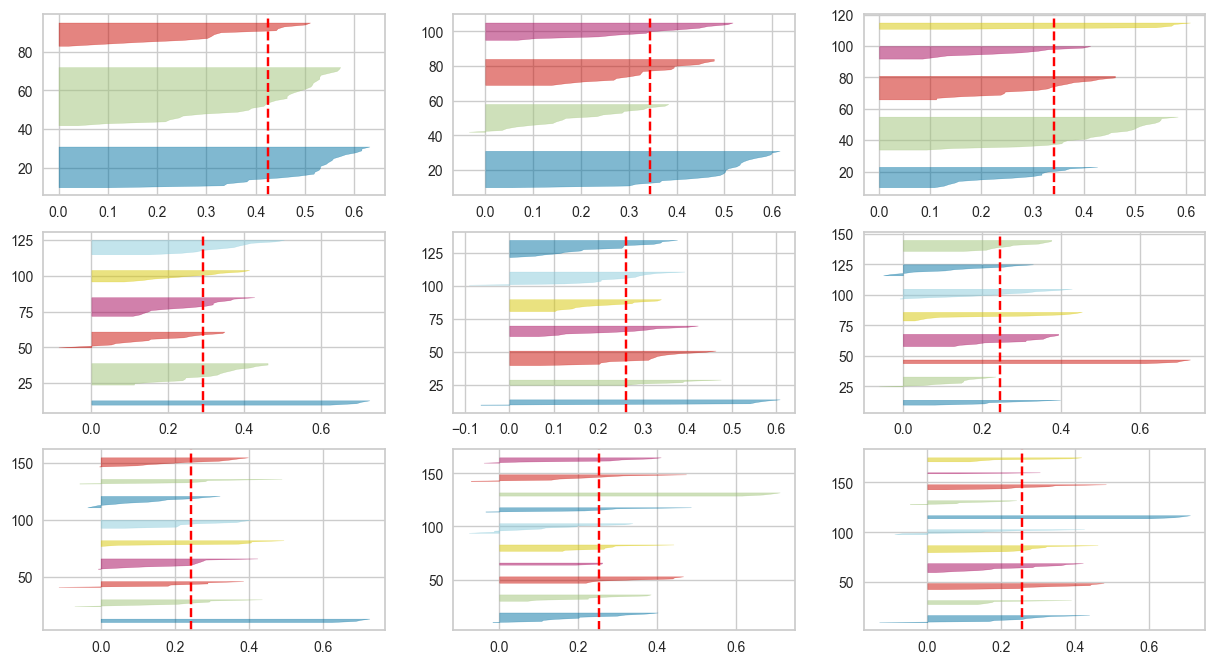

In [229]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 3, figsize=(15,8))
for i in range(3,12):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(umap_embeddings)


In [ ]:
# https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
from  sklearn.feature_extraction import CountVectorizer
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
c_tf_idf(res,len(res))

In [ ]:
for s in res:
    if len(s) == 0:
        print(len(s))

In [ ]:
from top2vec import Top2Vec
model = Top2Vec(documents=res,min_count=2,embedding_batch_size=8,speed='deep-learn',embedding_model='all-MiniLM-L6-v2')

In [ ]:
model.get_num_topics()

{0, 1}
2   0.4348795
   Topic  Count                       Name
0      0     38  0_thanks_like_great_thank
1      1     28    1_people_like_man_still


ValueError: X has 160 features, but KMeans is expecting 5 features as input.

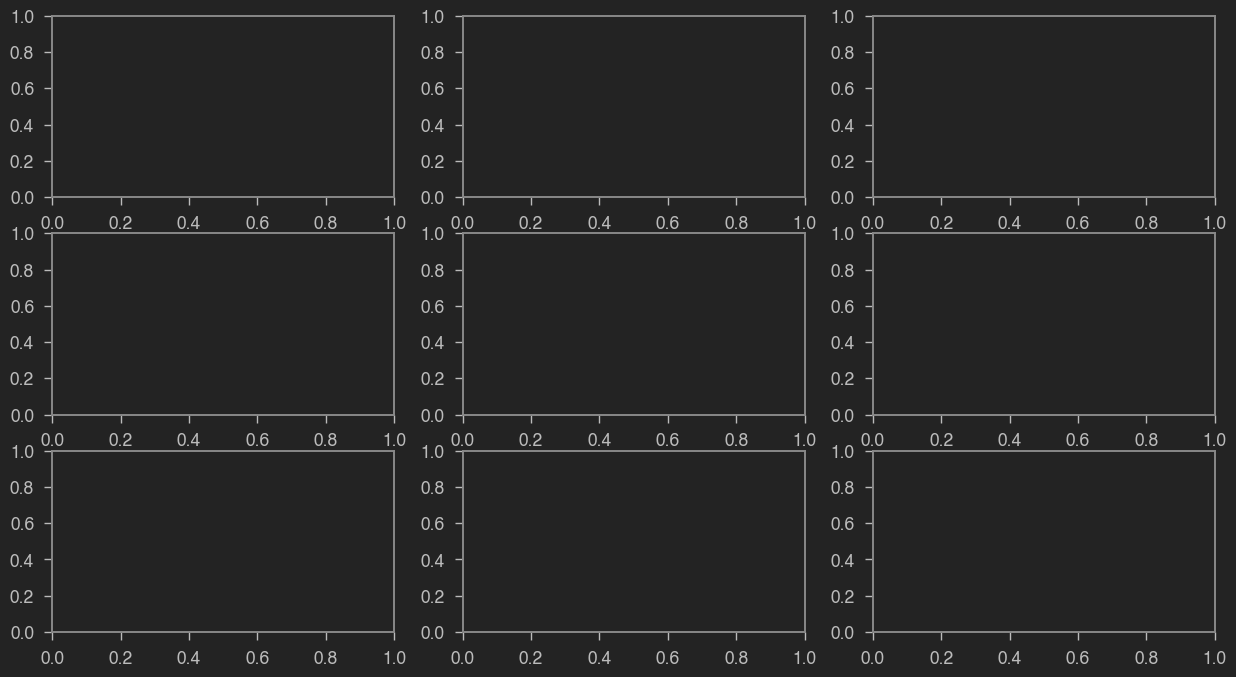

In [395]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import silhouette_visualizer
import json
from sklearn.metrics import silhouette_score
from transformers.pipelines import pipeline

embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")

data = res

embedder = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = embedder.encode(data, convert_to_tensor=True)

umap_model = umap.UMAP(n_neighbors=5, n_components=5, metric="cosine")
umap_embeddings = umap_model.fit_transform(embeddings)

umap_model = umap.UMAP(n_neighbors=5, n_components=5, metric="cosine")

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
fig, ax = plt.subplots(3, 3, figsize=(15, 8))

for i in range(2, 14):

    km = KMeans(n_clusters=i)
    topic_model = BERTopic(
        ctfidf_model=ctfidf_model,
        umap_model=umap_model,
        embedding_model="paraphrase-MiniLM-L6-v2",
        hdbscan_model=km,
        min_topic_size = 5
    )
    q, mod = divmod(i, 3)
    topics, probs = topic_model.fit_transform(data)
    print(set(km.labels_))
    #print(topic_model.get_topic_info())
    print(i,' ',silhouette_score(umap_embeddings,km.labels_))
    print(topic_model.get_topic_info())
    viz = SilhouetteVisualizer(km,ax[q-1][mod])
    viz.fit(X)


{0, 1}
2   0.5652369
   Topic  Count                    Name
0      0     39    0_thanks_like_go_use
1      1     27  1_guy_front_even_right
{0, 1, 2}
3   0.49876422
   Topic  Count                        Name
0      0     25      0_man_know_good_church
1      1     24  1_thanks_great_use_problem
2      2     17        2_get_work_rust_food
{0, 1, 2, 3}
4   0.40161502
   Topic  Count                       Name
0      0     25     0_man_front_still_know
1      1     18  1_use_free_chrome_problem
2      2     16       2_like_rust_get_work
3      3      7   3_book_ask_engineer_post
{0, 1, 2, 3, 4}
5   0.35877207
   Topic  Count                         Name
0      0     18      0_free_nice_chrome_idea
1      1     14      1_get_work_use_potatoes
2      2     13     2_man_police_trump_right
3      3     12        3_front_good_son_grip
4      4      9  4_book_engineer_advice_good
{0, 1, 2, 3, 4, 5}
6   0.38188794
   Topic  Count                              Name
0      0     14               

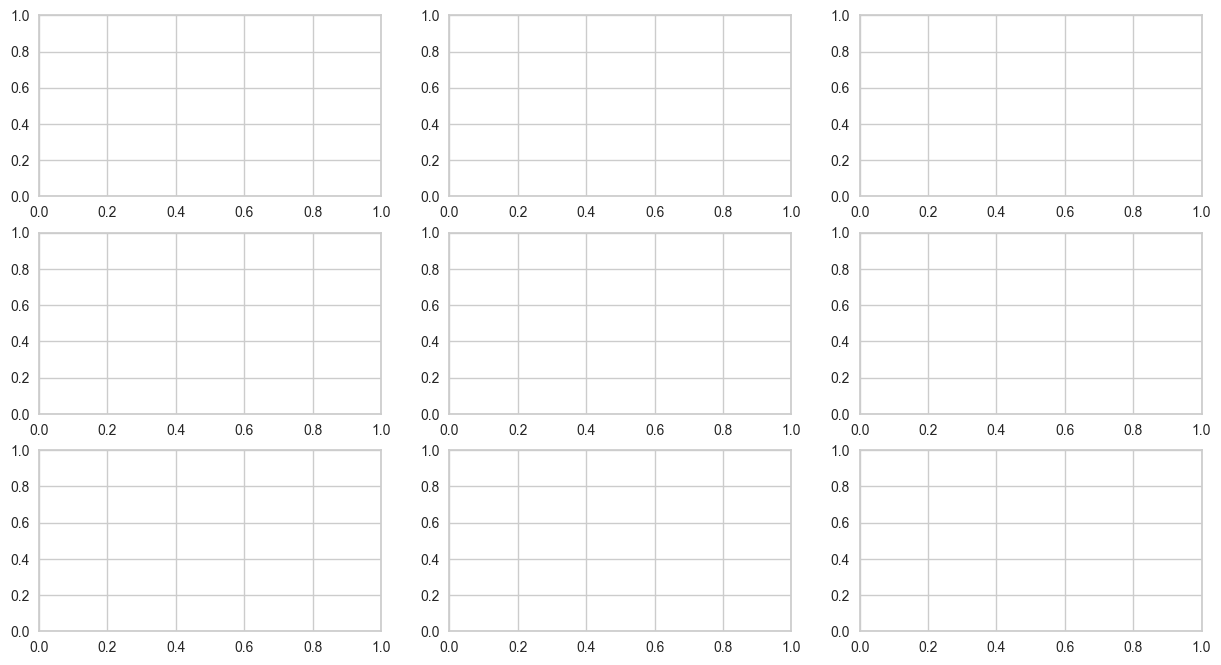

In [334]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.backend import WordDocEmbedder
from sklearn.cluster import KMeans
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
import json
from sklearn.metrics import silhouette_score
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer

from k_means_constrained import KMeansConstrained


# Document embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(
    embedding_model=embedding_model, word_embedding_model=ft
)

vec = CountVectorizer(stop_words='english',ngram_range=(1,2))
embeddings = word_doc_embedder.embed_documents(res)

umap_model = umap.UMAP(n_neighbors=5, n_components=5, metric="cosine")
umap_embeddings = umap_model.fit_transform(embeddings)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
#fig, ax = plt.subplots(3, 3, figsize=(15, 8))

for i in range(2, 14):

    km = KMeans(n_clusters=i)
    topic_model = BERTopic(
        ctfidf_model=ctfidf_model,
        umap_model=umap_model,
        embedding_model=word_doc_embedder,
        hdbscan_model=km,
        diversity=1
    )
    km.fit(umap_embeddings)
    q, mod = divmod(i, 3)
    topics, probs = topic_model.fit_transform(data)
    topic_model.update_topics(data, vectorizer_model=vec)
    print(set(km.labels_))
    # print(topic_model.get_topic_info())
    print(i, " ", silhouette_score(umap_embeddings, km.labels_))
    print(topic_model.get_topic_info())

In [393]:
km = KMeansConstrained(n_clusters=6)


topic_model = BERTopic(
    ctfidf_model=ctfidf_model,
    umap_model=umap_model,
    embedding_model=word_doc_embedder,
    diversity=1
)
topic_model.fit_transform(res,embeddings)
# topic_model.update_topics(res, vectorizer_model=vec)

([0,
  -1,
  -1,
  1,
  0,
  -1,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  -1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  -1,
  0,
  1,
  0,
  -1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  -1,
  0,
  0],
 array([0.9223719 , 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 0.84221397, 0.79669409,
        1.        , 0.81189738, 0.98829932, 0.9980645 , 0.94934851,
        0.957659  , 0.77083798, 1.        , 0.        , 1.        ,
        0.98710666, 0.95162926, 0.93085799, 1.        , 1.        ,
        0.88796273, 0.88077382, 0.69128406, 1.        , 0.74653739,
        0.81677682, 0.89492002, 0.82428928, 0.72006336, 0.        ,
        0.83994945, 1.        , 0.9277261 , 0.        , 1.        ,
        0.6832782 , 1.        , 0.76520284, 0.9730792 , 0.96083944,
        0.97658973, 0.75146621, 0.        , 1.  

In [394]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

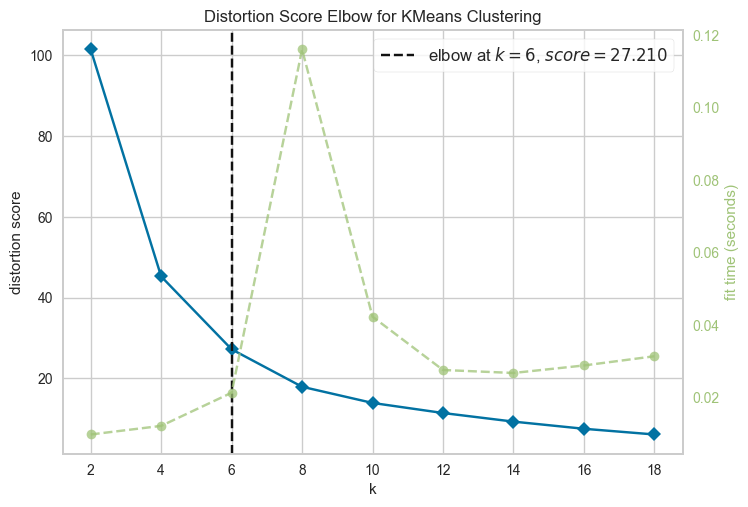

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [360]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans()
visualizer = KElbowVisualizer(km, k = range(2,20,2))
visualizer.fit(umap_embeddings)
visualizer.show()

In [ ]:
ft = api.load('fasttext-wiki-news-subwords-300')

In [304]:
import gensim

word_vectors = gensim.models.KeyedVectors.load_word2vec_format('./crawl-300d-2M.vec', binary=False)
word_vectors.save('./crawl-300d-2M')

In [316]:
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

# Document embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(embedding_model=embedding_model, word_embedding_model=ft)
topic_model = BERTopic(embedding_model=word_doc_embedder)

In [317]:
topic_model.fit_transform(res)

([-1,
  -1,
  -1,
  1,
  -1,
  -1,
  0,
  1,
  0,
  -1,
  1,
  0,
  0,
  0,
  1,
  0,
  -1,
  1,
  -1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  -1,
  1,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  -1,
  0,
  1,
  0,
  -1,
  1,
  1,
  1,
  1,
  -1,
  -1,
  -1,
  1,
  1,
  0,
  -1,
  -1,
  0,
  0],
 array([0.        , 0.        , 0.        , 0.97707764, 0.        ,
        0.        , 1.        , 1.        , 0.88344911, 0.        ,
        0.93430108, 0.82132315, 0.88171272, 0.93736679, 1.        ,
        0.96233419, 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.88428575, 1.        , 1.        , 1.        ,
        0.98886053, 0.83085621, 0.        , 1.        , 0.        ,
        0.86496757, 1.        , 0.        , 0.84964889, 0.        ,
        1.        , 1.        , 0.92247926, 0.        , 0.91365808,
        0.79104452, 0.90926888, 0.        , 1.        , 0.90926888,
        0.83550657, 0.79104452, 0.  

In [318]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,21,-1_good_one_like_cache
1,0,30,0_thanks_like_work_go
2,1,15,1_people_like_man_right


In [326]:
from sklearn.decomposition import PCA
rs = []
print(len(embeddings))
for i in range(2,len(embeddings),15):
    model = PCA(n_components=i)
    model.fit(embeddings)
    rs.append(model.explained_variance_ratio_.sum())

66


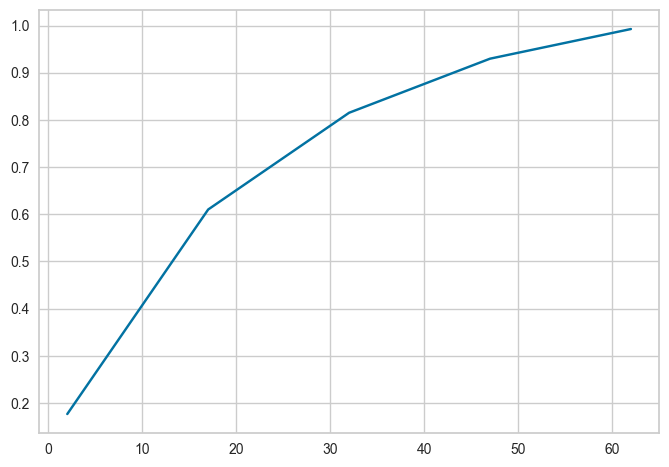

In [327]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots()
ax.plot(range(2,len(embeddings),15),rs)

In [257]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,38,0_to_the_you_and
1,1,28,1_the_and_of_to


In [258]:
topic_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.4489612713243437, 0.4652216896830224, 0.47831152636012003,
                    0.4846938142432452, 0.5169588122355774],
              'xaxis': 'x',
              'y': [it  , and  , you  , the  , to  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.44032374157101606, 0.4467594055384502, 0.46745841666039195,
                    0.47091221832508423, 0.5576039439195043],
              'xaxis': 'x2',
              'y': [he  , to  , of  , and  , the  ],
              'yaxis': 'y2'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 325.0,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Topic Word Scores',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.175], 'showgrid': True},
               'xaxis2': {'anchor': 'y2', 'domain': [0.275, 0.45], 'showgrid': True},
               'xaxis3': {'anchor': 'y3', 'domain': [0.55, 0.7250000000000001], 'showgrid': True},
               'xaxis4': {'anchor': 'y4', 'domain': [0.825, 1.0], 'showgrid': True},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis3': {'anchor': 'x3', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis4': {'anchor': 'x4', 'domain': [0.0, 1.0], 'showgrid': True}}
})

In [381]:
import gensim.corpora as corpora

data = json.load(open('example.json'))['res']
id2word = corpora.Dictionary(data)
id2word.filter_extremes(no_below=5,no_above=0.25)

texts = data

corpus = [id2word.doc2bow(text) for text in texts]


In [382]:
import gensim
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
id2word=id2word,
num_topics=10)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [383]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

pyLDAvis.enable_notebook()

gensimvis.prepare(lda_model,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.039321 -0.049928       1        1  18.175112
4     -0.079492  0.010749       2        1  13.695482
0      0.017484 -0.013319       3        1  12.420012
1      0.058610  0.061347       4        1  11.310847
5     -0.059371 -0.015492       5        1   8.801255
8     -0.044902  0.020417       6        1   8.183036
7      0.011337  0.024395       7        1   8.156679
6     -0.056686  0.030014       8        1   7.814856
2      0.065398 -0.091084       9        1   7.206148
9      0.126942  0.022901      10        1   4.236573, topic_info=           Term       Freq      Total Category  logprob  loglift
279         big  10.000000  10.000000  Default  30.0000  30.0000
127        book  27.000000  27.000000  Default  29.0000  29.0000
147     machine  13.000000  13.000000  Default  28.0000  28.0000
134    learning  29.000000  29.000000  Default  27.0000  27.0000
141         day  19.000000  19.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
61        thing   1.524775  22.523589  Topic10  -4.4994   0.4687
160     thought   1.189886  14.186699  Topic10  -4.7474   0.6830
103  understand   1.248764  18.871824  Topic10  -4.6991   0.4459
209     someone   1.192912  17.042285  Topic10  -4.7449   0.5021
4         every   1.170424  17.215207  Topic10  -4.7639   0.4730

[483 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76        1  0.211289       able
76        2  0.211289       able
76        3  0.105644       able
76        5  0.105644       able
76        6  0.105644       able
...     ...       ...        ...
22       10  0.128382        yes
106       1  0.356984  yesterday
106       4  0.178492  yesterday
106       5  0.178492  yesterday
106       7  0.178492  yesterday

[1574 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 6, 9, 8, 7, 3, 10])

In [400]:
new = json.load(open('./example1.json'))['res']

In [410]:
import nltk
import spacy


nlp = spacy.load('en_core_web_sm')

def process(text):
    return [t.text for t in nlp(text)]
process(new[0])



['cache',
 'invalidation',
 'really',
 'is',
 'one',
 'of',
 'the',
 'hardest',
 'problems',
 'in',
 'computer',
 'science',
 ' ',
 '[',
 "'",
 'if',
 'you',
 'do',
 'n’t',
 'have',
 'time',
 'for',
 'both',
 ',',
 'i',
 'recommend',
 'reading',
 'the',
 'original',
 'article',
 ':',
 'https://netflixtechblog.com/seeing-through-hardware-counters-a-journey-to-threefold-performance-increase-2721924a2822',
 "'",
 ',',
 "'",
 'the',
 'three',
 'hardest',
 'problems',
 'in',
 'cs',
 ' ',
 '\\n\\\\-',
 'cache',
 'invalidation\\n\\n\\\\-',
 'off',
 'by',
 'one',
 'errors\\n\\n\\\\-',
 'cache',
 'invalidation',
 "'",
 ',',
 "'",
 'one',
 'question',
 'i',
 'have',
 'is',
 'why',
 'this',
 'supertype',
 'cache',
 'is',
 'shared',
 'between',
 'threads',
 '.',
 'it',
 'seems',
 'like',
 'an',
 'ideal',
 'candidate',
 'for',
 'something',
 'that',
 'should',
 'be',
 'made',
 'thread',
 'local',
 '.',
 "'",
 ',',
 "'",
 'get',
 'rid',
 'of',
 'caches',
 '.',
 ' ',
 'no',
 'cache',
 ',',
 'no',
 'c

In [420]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction import TfidfVectorizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import string

data = json.load(open('example1.json'))['res']

In [447]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /Users/will/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/will/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/will/nltk_data...


True

In [445]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
stopwords = set(nltk.corpus.stopwords.words('english'))


class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        
        # Pre-proccessing of one document at the time
        
        # Removing puntuation
        translator_1 = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        document = document.translate(translator_1)

        # Removing numbers
        document = re.sub(r'\d+', ' ', document)

        # Removing special characters
        document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)

        # The document is a string up to now, after word_tokenize(document) we'll work on every word one at the time
        for token in word_tokenize(document):
            
            # Removing spaces
            token = token.strip()
            
            # Lemmatizing
            token = self.lemmatizer.lemmatize(token)

            # Removing stopwords
            if token not in stopwords and len(token) > 2:
                lemmas.append(token)
        return lemmas



In [502]:
model = TfidfVectorizer(min_df=0.1,max_df=0.5,tokenizer=LemmaTokenizer())
new = model.fit_transform(data)
new

<90x470 sparse matrix of type '<class 'numpy.float64'>'
	with 7839 stored elements in Compressed Sparse Row format>

In [503]:
import numpy as np
comps = np.geomspace(2,100,10)
print(comps)
plots = []
for comp in comps:
    svd = TruncatedSVD(int(comp))
    svd.fit(new)
    plots.append(svd.explained_variance_ratio_.sum())
    


[  2.           3.08890421   4.77066461   7.368063    11.37962041
  17.57527869  27.14417617  41.92288002  64.74788029 100.        ]


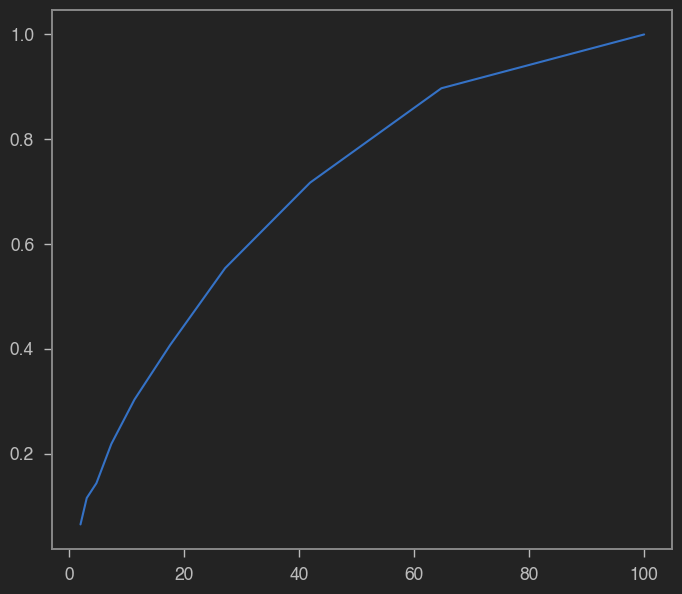

In [504]:
fig, ax = plt.subplots()

ax.plot(comps,plots)

0 0
0.04265096617454292
0 1
0.05481769117456816
0 2
0.04823751249678873
1 0
0.041852032966607694
1 1
0.05054495014363854
1 2
0.04563983253037609


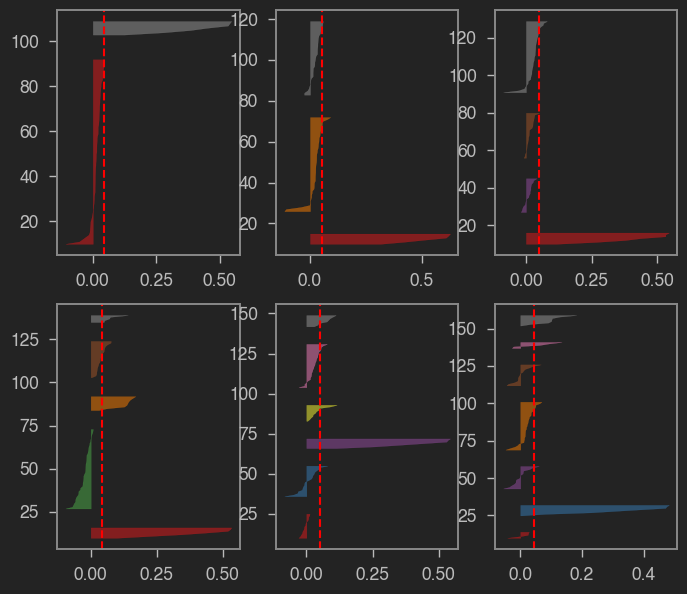

In [505]:
choice = 75

model = TruncatedSVD(choice)
reduced = model.fit_transform(new)

fig,ax = plt.subplots(2,3)
for i,k in enumerate(range(2,8)):
    a,q  = divmod(i,3)
    print(a,q)
    model = KMeans(k)
    viz = SilhouetteVisualizer(model,ax[a][q])
    viz.fit(reduced)
    print(silhouette_score(reduced,model.labels_))
fig.show()

In [ ]:
from sklearn.topi